In [1]:
#Not all these packages are required but they are here for completeness
import glob
import io
from ipywidgets import interact
from ipywidgets import fixed
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops
import seaborn as sns
import SimpleITK as sitk
from skimage.color import rgb2hed
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import morphology
import time
import warnings

In [2]:
# Import package 

BASE_DIR = Path().resolve()
HEMNET_DIR = BASE_DIR.parent.joinpath('HEMnet')

os.chdir(HEMNET_DIR)
from slide import *
from utils import *

In [3]:
# User Input parameters

SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005')
OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg')

ALIGNMENT_MAG = 2
TILE_MAG = 5
VERBOSE = True

In [4]:
# Find Slides

slides = []
for slide in SLIDES_PATH.glob('*.svs'):
    name = slide.name
    slides.append(name)
slides.sort()
slides

['1820_N_10545A_2_HandE.svs',
 '1820_N_10545A_4_TP53.svs',
 '1820_T_105452F_2_HandE.svs',
 '1820_T_105452F_4_TP53.svs',
 '2065_N_12752A_2_HandE.svs',
 '2065_N_12752A_4_TP53.svs',
 '2065_T_12756A_2_HandE.svs',
 '2065_T_12756A_4_TP53.svs',
 '2112_N_12341B_2_HandE.svs',
 '2112_N_12341B_4_TP53.svs',
 '2112_T_12335F_2_HandE.svs',
 '2112_T_12335F_4_TP53.svs',
 '2148_N_11397A_2_HandE.svs',
 '2148_N_11397A_4_TP53.svs',
 '2148_T_11393A_2_HandE.svs',
 '2148_T_11393A_4_TP53.svs',
 '2171_N_11521A_2_HandE.svs',
 '2171_N_11521A_4_TP53.svs',
 '2171_T_11524A_2_HandE.svs',
 '2171_T_11524A_4_TP53.svs']

In [5]:
TP53_slides = [slide for slide in slides if 'TP53' in slide]
HE_slides = [slide for slide in slides if 'HandE' in slide]
Paired_slides = list(zip(TP53_slides, HE_slides))
Paired_slides

[('1820_N_10545A_4_TP53.svs', '1820_N_10545A_2_HandE.svs'),
 ('1820_T_105452F_4_TP53.svs', '1820_T_105452F_2_HandE.svs'),
 ('2065_N_12752A_4_TP53.svs', '2065_N_12752A_2_HandE.svs'),
 ('2065_T_12756A_4_TP53.svs', '2065_T_12756A_2_HandE.svs'),
 ('2112_N_12341B_4_TP53.svs', '2112_N_12341B_2_HandE.svs'),
 ('2112_T_12335F_4_TP53.svs', '2112_T_12335F_2_HandE.svs'),
 ('2148_N_11397A_4_TP53.svs', '2148_N_11397A_2_HandE.svs'),
 ('2148_T_11393A_4_TP53.svs', '2148_T_11393A_2_HandE.svs'),
 ('2171_N_11521A_4_TP53.svs', '2171_N_11521A_2_HandE.svs'),
 ('2171_T_11524A_4_TP53.svs', '2171_T_11524A_2_HandE.svs')]

In [258]:
SLIDE_NUM = 8
PREFIX = Paired_slides[SLIDE_NUM][0][:-7]
print(PREFIX)
tp53_name, he_name = Paired_slides[SLIDE_NUM]
tp53_slide = open_slide(str(SLIDES_PATH.joinpath(tp53_name)))
he_slide = open_slide(str(SLIDES_PATH.joinpath(he_name)))

2171_N_11521A_4_T


In [152]:
def thumbnail(img, size = (1000,1000)):
    img_thumbnail = img.copy()
    img_thumbnail.thumbnail(size)
    return img_thumbnail

In [259]:
he = read_slide_at_mag(he_slide, ALIGNMENT_MAG)
tp53 = read_slide_at_mag(tp53_slide, ALIGNMENT_MAG)

In [260]:
thumbnail(he)

In [261]:
thumbnail(tp53)

In [262]:
#Convert to grayscale
tp53_gray = tp53.convert('L')
he_gray = he.convert('L')
#Convert to ITK format
tp53_itk = get_itk_from_pil(tp53_gray)
he_itk = get_itk_from_pil(he_gray)

In [184]:
def sitk_transform_rgb(moving_rgb_img, fixed_rgb_img, transform, interpolator = sitk.sitkLinear):
    transformed_channels = []
    r_moving, g_moving, b_moving, = moving_rgb_img.convert('RGB').split()
    r_fixed, g_fixed, b_fixed = fixed_rgb_img.convert('RGB').split()
    for moving_img, fixed_img in [(r_moving, r_fixed), (g_moving, g_fixed), (b_moving, b_fixed)]:
        moving_img_itk = get_itk_from_pil(moving_img)
        fixed_img_itk = get_itk_from_pil(fixed_img)
        transformed_img = sitk.Resample(moving_img_itk, fixed_img_itk, transform, 
                            interpolator, 0.0, moving_img_itk.GetPixelID())
        transformed_channels.append(get_pil_from_itk(transformed_img))
    rgb_transformed = Image.merge('RGB', transformed_channels)
    return rgb_transformed    

In [263]:
#Check Initial Registration
fixed_img = he_itk
moving_img = tp53_itk
initial_transform = sitk.CenteredTransformInitializer(fixed_img, moving_img, sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
moving_resampled = sitk.Resample(moving_img, fixed_img, initial_transform, 
                                 sitk.sitkLinear, 0.0, moving_img.GetPixelID())

In [264]:
moving_rgb = sitk_transform_rgb(tp53, he, initial_transform)

In [265]:
thumbnail(show_alignment(he, moving_rgb, prefilter = True))

### Image Registration

To enable labelling of H&E images from the TP53 images, these two images must be aligned to each other. Due to differences in sample preparation and imaging, these images are often not aligned so we need to register them to each other. 

In image registration, one image is set a fixed image and the other set as a moving image - it is the moving image that is tranformed to best align it to the fixed image. Here we set the H&E image as the fixed image and the TP53 Image as the moving image. We do this as the H&E image will later be used to train a convolutional neural network and we want the network to be able to use original patient H&E images. Thus, it is best that the images used to the train the network is in the same format as patient samples. 

Before registering our images, we must first tell elastix what parameters we wish to use. Here we tell elastix to perform three types of transforms in order: rigid, affine and b-spline. Each successive method is more complex and with increase degrees of freedom. We begin with a simple registration method to ensure that the large features in our image are registered properly and that we do not get stuck in local minima. 

In [145]:
"""
def elastix_params():
    a_param_map = sitk.GetDefaultParameterMap('affine')
    a_param_map['MaximumNumberOfIterations'] = ['6000']
    a_param_map['NumberOfSpatialSamples'] = ['100000']
    a_param_map['NumberOfSamplesForExactGradient'] = ['100000']
    b_param_map = sitk.GetDefaultParameterMap('bspline')
    b_param_map['NumberOfResolutions'] = ['7']
    b_param_map['GridSpacingSchedule'] = ['1.0','1.0','1.0','1.0','1.0','1.0','1.0']
    b_param_map['Transform'] = ['RecursiveBSplineTransform']
    b_param_map['MaximumNumberOfIterations'] = ['6000']
    b_param_map['NumberOfSpatialSamples'] = ['100000']
    b_param_map['NumberOfSamplesForExactGradient'] = ['100000']
    b_param_map['FinalGridSpacingInPhysicalUnits'] = ['80000','20000','4960','1280', '320', '80', '20']
    b_param_map['Metric'] = ['NormalizedMutualInformation']   #Faster with unnormalised version
    param_map_vector = sitk.VectorOfParameterMap()
    param_map_vector.append(a_param_map)
    param_map_vector.append(b_param_map)
    return param_map_vector
"""
def elastix_params():
    r_param_map = sitk.GetDefaultParameterMap('rigid')
    r_param_map['NumberOfResolutions'] = ['30']
    r_param_map['MaximumNumberOfIterations'] = ['2000']
    r_param_map['NumberOfSpatialSamples'] = ['50000']
    #a_param_map = sitk.GetDefaultParameterMap('affine')
    #a_param_map['NumberOfResolutions'] = ['17']
    #b_param_map = sitk.GetDefaultParameterMap('bspline')
    #b_param_map['Transform'] = ['RecursiveBSplineTransform']
    #b_param_map['Metric'] = ['NormalizedMutualInformation']
    #b_param_map['NumberOfJacobianMeasurements'] = ['100000']
    #b_param_map['NumberOfResolutions'] = ['7']
    #b_param_map['GridSpacingSchedule'] = ['1.0','1.0','1.0','1.0','1.0','1.0','1.0']
    #b_param_map['FinalGridSpacingInPhysicalUnits'] = ['80000','20000','4960','1280', '320', '80', '20']
    param_map_vector = sitk.VectorOfParameterMap()
    param_map_vector.append(r_param_map)
    #param_map_vector.append(a_param_map)
    #param_map_vector.append(b_param_map)
    return param_map_vector

In [146]:
param_map = elastix_params()

In [20]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [21]:
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*sitk.GetArrayViewFromImage(fixed) + alpha*sitk.GetArrayViewFromImage(moving)
    fig, ax = plt.subplots(figsize = (10,10))
    ax.imshow(img,cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()

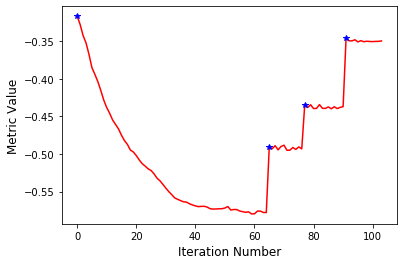

Final metric value: -0.3496553531659787
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 13.


In [254]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.15)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4,2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_img, sitk.sitkFloat32))

print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

In [127]:
moving_resampled = sitk.Resample(moving_img, fixed_img, final_transform, sitk.sitkLinear, 0.0, moving_img.GetPixelID())

In [63]:
interact(display_images_with_alpha, image_z=(0,1), alpha=(0.0,1.0,0.1), fixed = fixed(fixed_img), moving=fixed(moving_resampled));


interactive(children=(IntSlider(value=0, description='image_z', max=1), FloatSlider(value=0.5, description='al…

In [255]:
moving_rgb_final = sitk_transform_rgb(tp53, he, final_transform)

In [256]:
thumbnail(show_alignment(he, moving_rgb_final, prefilter = True))

In [147]:
start = time.time()

elastix = sitk.ElastixImageFilter()

elastix.SetFixedImage(fixed_img)
elastix.SetMovingImage(moving_img)
elastix.LogToFileOn()

elastix.SetParameterMap(param_map)
#elastix.LogToConsoleOn()
elastix.Execute()

transform_param_map = elastix.GetTransformParameterMap()

end = time.time()
print(end - start)

957.7157192230225


In [148]:
start = time.time()
tp53_aligned = transform_rgb(tp53, transform_param_map)
end = time.time()
print(end - start)

7.746452331542969


In [149]:
start = time.time()
tp53_filtered = filter_green(tp53_aligned)
he_filtered = filter_green(he)
green_end = time.time()
tp53_filtered = filter_grays(tp53_filtered, tolerance = 3)
he_filtered = filter_grays(he_filtered, tolerance = 15)
gray_end = time.time()
print('Time to Filter Green: {0}'.format(green_end - start))
print('Time to Filter Gray: {0}'.format(gray_end - green_end))

Time to Filter Green: 0.7474393844604492
Time to Filter Gray: 1.137402057647705


In [150]:
comparison = show_alignment(he_filtered, tp53_filtered)

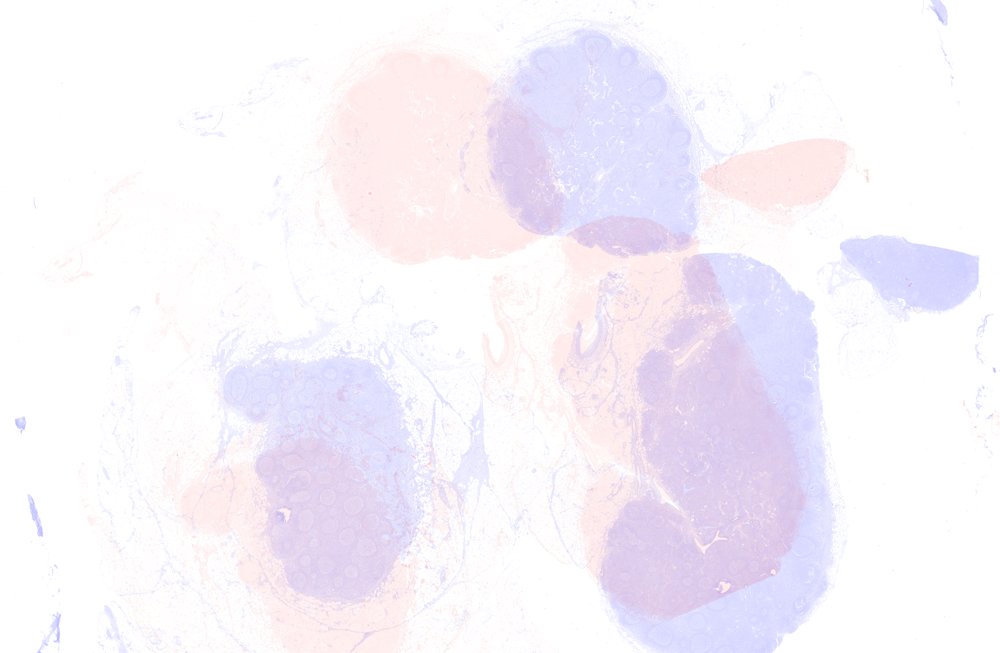

In [151]:
thumbnail(comparison)

In [19]:
comparison.convert('RGB').save(OUTPUT_PATH.joinpath(PREFIX + 'comparison_norm.jpeg'), 'JPEG')